In [1]:
import numpy as np
import torch
from mpc_mpnet_planner import MPCMPNetPlanner
from matplotlib import pyplot as plt
from mpnet.sst_envs.utils import load_data, visualize_point, get_obs
import pickle
from params.sst_step5_s1024_e32 import get_params


In [2]:
env_id = 0
traj_id = 3
obs_list = get_obs('acrobot_obs', env_id)
data = load_data('acrobot_obs', env_id, traj_id)
ref_path = data['path']
env_vox = torch.from_numpy(np.load('mpnet/sst_envs/acrobot_obs_env_vox.npy')[env_id]).unsqueeze(0).float()
params = get_params(ref_path[-1])

In [3]:
## for params
n_t = 5
state_dim = 4
control_dim = 1
weights = np.ones(state_dim)*1
weights[2:] = 0.2
n_sample = 1024
n_elite = 32
t = 1e-1
dt = 2e-2

mu_t, sigma_t = 1e-1, 4e-1
t_min, t_max = 0, 5e-1

mu_u = np.zeros((n_t*control_dim))
sigma_u_diag = np.ones(n_t*control_dim)
sigma_u_diag[:] = 4
sigma_u = np.diag(sigma_u_diag)
params = {
    'n_sample': n_sample,
    'n_elite': n_elite,
    'n_t': n_t,
    'weights': weights,
    'mu_u': mu_u,
    'sigma_u': sigma_u,
    't': t,
    'dt': dt,

    'mu_t': np.ones(n_t) * mu_t,
    'sigma_t': np.identity(n_t)*sigma_t,
    't_min': t_min,
    't_max': t_max,

    'state_dim': state_dim,
    'control_dim': control_dim,
    'converge_radius': 1e-1,
    'drop_radius': 5,
    'goal_radius': 10, #np.sqrt(2),
    'max_it': 5,
    'rolling_count': n_t,
    'bk_it': 2,
    'final_goal': ref_path[-1],
    'mpc_mode': 'solve',#'mpc_mode': 'rolling'
    'max_plan_it': 300,
    
    
#     'planning_mode': 'line_search',
    'planning_mode': 'tree',
    'delta_near': 1,
    'delta_drain': 1e-3,
#     'tree_sample': False,
    'tree_sample': True
}


In [4]:
import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')
from sparse_rrt import _sst_module
class AcrobotDistance(_sst_module.IDistance):
    '''
    Custom distance function for acrobot in python (reimplementation of cpp distance function)
    '''
    def angular_error(self, state, goal):
        error = np.abs(state - goal)
        if error > np.pi:
            error = np.pi * 2 - error
        return error
    
    def distance(self, state, goal):
        return self.angular_error(state[0], goal[0]) * params['weights'][0] +\
            self.angular_error(state[1], goal[1]) * params['weights'][1] + \
            (state[2] - goal[2]) ** 2 * params['weights'][2] +\
            (state[3] - goal[3]) ** 2 * params['weights'][2]

In [5]:
%%time
mpc_mpnet = MPCMPNetPlanner(params,
                            ref_path[0], 
                            ref_path[-1],
                            env_vox,
                            system="acrobot_obs",
                            setup="default_norm",
                            #setup="default_norm_aug",
#                             setup="norm_nodiff_noaug_20step2e-2",
                            ep=5000,
                            obs_list=obs_list[env_id], verbose=True,
                            #distance_func=AcrobotDistance()
                           )
mpc_mpnet.mpnet.train()
# mpc_mpnet.mpnet.eval()
mpc_mpnet.reset_sst_backend()

it = 0
while it < 100 and not mpc_mpnet.reached:
    mpc_mpnet.reset()
    for i in range(20):
        print('iteration:{}, it:{}'.format(i, it))
        mpc_mpnet.step()
        if mpc_mpnet.reached:
            break
        it += 1

print(sum(mpc_mpnet.costs),'ref:', sum(data['cost']))
# mpc_mpnet.params['tree_sample'] = True
# while it < 100 and not mpc_mpnet.reached:
# #     mpc_mpnet.reset()
#     print('iteration:{}, it:{}'.format(i, it))
#     mpc_mpnet.step()
#     if mpc_mpnet.reached:
#         break
#     it += 1

iteration:0, it:0
[69.11109548]
0.4329608740979191 inf
converged at  0
loss: [0.01208755]
iteration:1, it:1
[67.10356289]
0.13197507384646315 inf
converged at  0
loss: [0.01065482]
iteration:2, it:2
[64.82492224]
0.1451174870244341 inf
converged at  1
loss: [0.00263664]
iteration:3, it:3
[62.48188545]
1.9958937755897548 inf
1.304125475178224 1.9958937755897548
converged at  2
loss: [0.070476]
iteration:4, it:4
[38.80104773]
0.3681129328119722 inf
converged at  0
loss: [0.08277941]
iteration:5, it:5
[33.39528093]
0.4795377183205168 inf
converged at  0
loss: [0.01326795]
iteration:6, it:6
[67.09409928]
1.7883061071900679 inf
1.4606536066320785 1.7883061071900679
1.3458182023508556 1.4606536066320785
1.3127886801440556 1.3458182023508556
converged at  4
loss: [0.07463328]
iteration:7, it:7
[25.62451765]
0.3722995269082493 inf
converged at  1
loss: [0.04316977]
iteration:8, it:8
[23.22158828]
0.4579732478102085 inf
converged at  2
loss: [0.09274453]
iteration:9, it:9
[23.69069424]
0.371802

In [6]:
mpc_mpnet.tree_backend.get_solution()

(array([[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.3023016 ,  0.66348862, -1.12356448,  2.63135355],
        [-0.42680659,  0.96977835, -0.8808262 ,  2.3858799 ],
        [-0.49762927,  1.21617091, -0.05822394,  1.04324721],
        [ 0.81306743, -2.56708997, -2.58819621, -0.53683838],
        [-0.14036436, -2.30918204, -3.778719  ,  2.29220568],
        [ 1.22281569,  2.45176749,  2.80214248, -2.87796019],
        [ 1.62435585,  1.94888273, -0.28606126, -0.15296255],
        [ 1.4486478 ,  2.01948749, -1.83666642,  1.01353622],
        [-2.2462465 , -1.6108745 , -1.32521975,  1.56436124]]),
 array([[4.64018415e-310],
        [4.64018382e-310],
        [4.64018447e-310],
        [4.64018449e-310],
        [4.64013515e-310],
        [4.64013563e-310],
        [4.64013523e-310],
        [4.64013525e-310],
        [4.64018420e-310]]),
 array([0.92087332, 0.12132026, 0.64248085, 1.23364948, 0.7095307 ,
        1.2381554 , 0.30312264, 0.18634181, 1.02680391]))

<IPython.core.display.Javascript object>


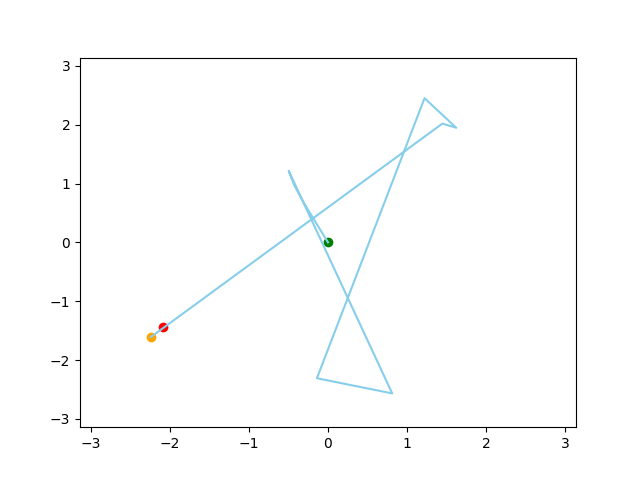

[[-2.2462465  -1.6108745  -1.32521975  1.56436124]] [[-2.09508395 -1.44473031 -0.98695053  1.15902916]]


In [7]:
%matplotlib notebook

# if mpc_mpnet.reached:
path = np.array(mpc_mpnet.path)
plt.plot(path[:,0], path[:,1], color='skyblue')
plt.scatter(ref_path[0,0], ref_path[0,1], color='green')
plt.scatter(ref_path[-1,0], ref_path[-1,1], color='red')
plt.scatter(mpc_mpnet.state[:,0], mpc_mpnet.state[:,1], color='orange')

samples = np.array(mpc_mpnet.samples)
# plt.scatter(samples[:,0], samples[:,1], color='green')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

print(mpc_mpnet.state, mpc_mpnet.goal)

In [15]:
# %matplotlib notebook
# samples = np.array(mpc_mpnet.samples)
# plt.plot(samples[:,0], samples[:,1], color='green')
# plt.scatter(ref_path[0,1], ref_path[0,1], color='orange')
# plt.scatter(ref_path[-1,1], ref_path[-1,1], color='red')

<IPython.core.display.Javascript object>


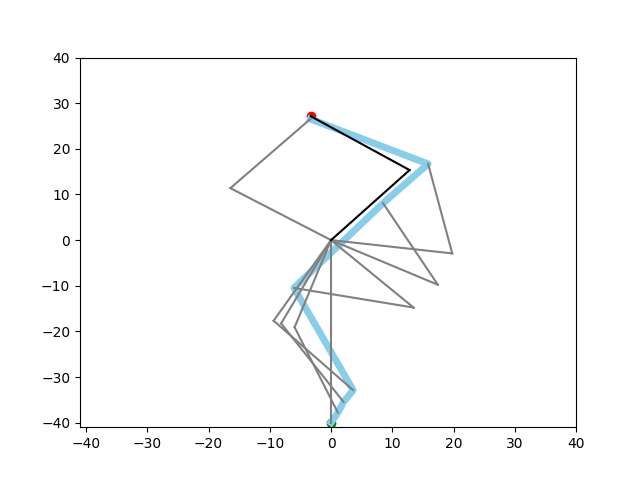

(-41.0, 40.0)

In [15]:
%matplotlib notebook

endeff = []#[[0, -40]]
node1 = []#[[0, -20]]
for p in path:
    ex1, ey1, ex2, ey2 = visualize_point(p)
    endeff.append([ex2, ey2])
    node1.append([ex1, ey1])

endeff = np.array(endeff)
node1 = np.array(node1)
x1, y1, x2, y2 = visualize_point(ref_path[-1])


plt.plot(endeff[:,0], endeff[:,1], color='skyblue', linewidth=5)
plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

for i in range(endeff.shape[0]):
    plt.plot([0, node1[i,0]], [0, node1[i,1]], color='gray')
    plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='gray')
plt.plot([0, x1], [0, y1], color='black')
plt.plot([x1, x2], [y1, y2], color='black')
    
plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(x2, y2, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)
